## CartPole Skating
- apply Q-Learning to a problem with continuous state
- use a simplified version of balancing known as a CartPole problem. 
In the cartpole world, we have a horizontal slider that can move left or right, and the goal is to balance a vertical pole on top of the slider.

In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import random
gym.__version__

'0.29.1'

### initialize a cartpole environment

In [14]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
print("Action space: ", env.action_space)
print("Observation space: ", env.observation_space)
print("sample observation: ", env.observation_space.sample())

Action space:  Discrete(2)
Observation space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
sample observation:  [-4.2988205e+00  3.2696322e+37  8.7885417e-02 -2.2151770e+38]


run a short simulation for 100 steps to see how the environment works

In [29]:
env.reset()

for i in range(100):
    env.render()
    env.step(env.action_space.sample())
env.close()

The observation vector that is returned at each step of the simulation contains the following values:

- Position of cart
- Velocity of cart
- Angle of pole
- Rotation rate of pole

In [ ]:
done = False
while not done:
    env.render()    
    obs, reward, done, info, *_ = env.step(env.action_space.sample())
    print(f"{obs} -> {reward}")
    if done:
        env.reset()
env.close()

In [ ]:
print(env.observation_space.high)
print(env.observation_space.low)

### State discretization
- **Divide into bins**
    If we know the interval of a certain value, we can divide this interval into a number of bins, and then replace the value by the bin number that it belongs to. This can be done using the numpy digitize method. In this case, we will precisely know the state size, because it will depend on the number of bins we select for digitalization.
- **Linear interpolation**
    Use linear interpolation to bring values to some finite interval (say, from -20 to 20), and then convert numbers to integers by rounding them. This gives us a bit less control on the size of the state, especially if we do not know the exact ranges of input values. 

In [4]:
# take the observation and produce a tuple of 4 integer values
def discretize(x):
    return tuple((x/np.array([0.25, 0.25, 0.01, 0.1])).astype(int))

In [5]:
# another discretization method using bins
def create_bins(i, num):
    return np.arange(num+1)*(i[1]-i[0])/num+i[0]

print("Sample bins for interval (-5, 5) with 10 bins\n",create_bins((-5,5), 10))

ints = [(-5,5),(-2,2),(-0.5,0.5),(-2,2)] # intervals of values for each parameter
nbins = [20,20,10,10] # number of bins for each parameter
bins = [create_bins(ints[i], nbins[i]) for i in range(4)]

def discretize_bins(x):
    return tuple(np.digitize(x, bins[i]) for i in range(4))

Sample bins for interval (-5, 5) with 10 bins
 [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


In [ ]:
env.reset()

done = False
while not done:
    env.render()
    obs, rew, done, info, *_ = env.step(env.action_space.sample())
    #print(discretize_bins(obs))
    print(discretize(obs))
env.close()

### The Q-Table structure
the size of state vector is 20x20x10x10x2 (here 2 is the dimension of action space, and first dimensions correspond to the number of bins we have selected to use for each of the parameters in observation space)

precise dimensions of the observation space are not known, in the case of the discretize function

In [6]:
Q = {}
actions =(0, 1)
# return a list of Q-Table values for a given state that corresponds to all possible actions.
# If the entry is not present in the Q-Table, return 0 as the default.
def qvalues(state):
    return [Q.get((state,a),0) for a in actions]


### Q-Learning

Hyperparameter

In [7]:
initial_alpha = 1
initial_epsilon = 0.2
final_epsilon = 0.99

decay_rate = 1/140000
epochs = 140000

# Function to calculate the learning rate at each epoch
def get_alpha(epoch, initial_alpha, decay_rate):
    return initial_alpha * np.exp(-decay_rate * epoch)

# Function to calculate epsilon at each epoch
def get_epsilon(epoch, initial_epsilon, final_epsilon, epochs):
    return initial_epsilon + (final_epsilon - initial_epsilon) * (epoch / epochs)

gamma = 0.9 # discount factor


Calculate average cumulative reward, over a number of simulations. 

In [8]:
def probs(v, eps=1e-4):
    v = v - v.min() + eps
    v = v / v.sum()
    return v

Qmax = 0
cum_rewards = []
rewards = []

for epoch in range(epochs):
    env.reset()
    done = False
    cumulative_reward = 0
    obs, rew, done, info, *_ = env.step(env.action_space.sample())
    
    alpha = get_alpha(epoch, initial_alpha, decay_rate)
    epsilon = get_epsilon(epoch, initial_epsilon, final_epsilon, epochs)

    # == do the simulation ==
    while not done:

        s = discretize(obs)
        if random.random()<epsilon:
            # exploitation - chose the action according to Q-Table probabilities
            v = probs(np.array(qvalues(s)))
            a = random.choices(actions,weights=v)[0]
        else:
            # exploration - randomly chose the action
            a = np.random.randint(env.action_space.n)

        obs, rew, done, info, *_ = env.step(a)
        cumulative_reward += rew
        ns = discretize(obs)
        Q[(s,a)] = (1 - alpha) * Q.get((s,a),0) + alpha * (rew + gamma * max(qvalues(ns)))
    cum_rewards.append(cumulative_reward)
    rewards.append(cumulative_reward)
    # == Periodically print results and calculate average reward ==
    if epoch%5000==0:
        print(f"{epoch}: {np.average(cum_rewards)}, alpha={alpha}, epsilon={epsilon}")
        if np.average(cum_rewards) > Qmax:
            Qmax = np.average(cum_rewards)
            Qbest = Q
        cum_rewards=[]

0: 24.0, alpha=1.0, epsilon=0.2
5000: 26.8128, alpha=0.96491594437237, epsilon=0.22821428571428573
10000: 27.5582, alpha=0.9310627797040227, epsilon=0.25642857142857145
15000: 27.5226, alpha=0.898397321348071, epsilon=0.28464285714285714
20000: 28.6042, alpha=0.8668778997501816, epsilon=0.31285714285714283
25000: 29.9524, alpha=0.8364643072929833, epsilon=0.3410714285714286
30000: 31.6934, alpha=0.8071177470053893, epsilon=0.36928571428571433
35000: 33.8972, alpha=0.7788007830714049, epsilon=0.3975
40000: 37.7218, alpha=0.751477293075286, epsilon=0.4257142857142857
45000: 41.683, alpha=0.7251124219221319, epsilon=0.45392857142857146
50000: 45.1308, alpha=0.6996725373751304, epsilon=0.48214285714285715
55000: 50.6172, alpha=0.6751251871527363, epsilon=0.510357142857143
60000: 56.4248, alpha=0.6514390575310556, epsilon=0.5385714285714286
65000: 60.895, alpha=0.6285839333986252, epsilon=0.5667857142857143
70000: 67.7466, alpha=0.6065306597126334, epsilon=0.595
75000: 74.2746, alpha=0.5852

### Plot Trainning Progress

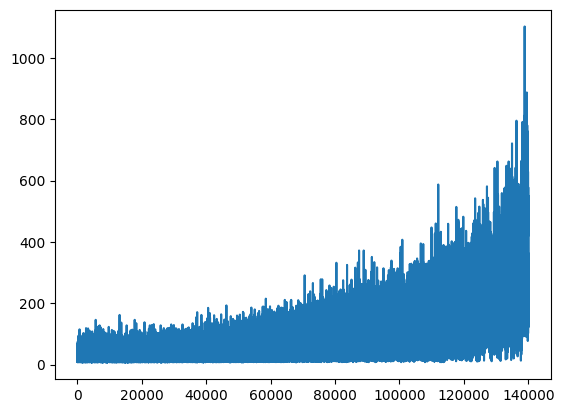

In [9]:
plt.plot(rewards)

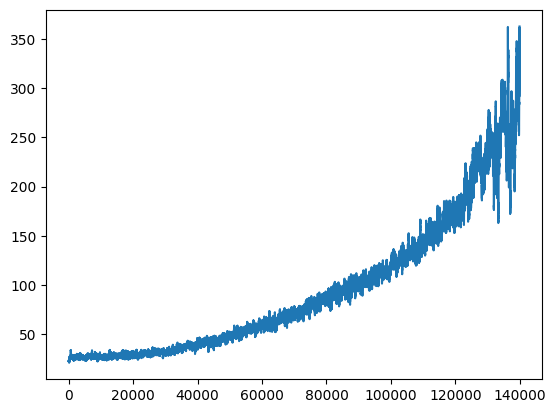

In [10]:
# calculate the running average over a series of experiments, let's say 100.
def running_average(x, window):
    return np.convolve(x, np.ones(window)/ window, mode='valid')
plt.plot(running_average(rewards, 100))

### Varying hyperparameters
- alpha (Learning rate)
- epsilon

### Seeing the result in action

In [13]:
env.reset()
done = False
obs, rew, done, info, *_ = env.step(env.action_space.sample())
while not done:
    s = discretize(obs)
    env.render()
    v = probs(np.array(qvalues(s)))
    a = random.choices(actions, weights=v)[0]
    obs, _, done, _, *_ = env.step(a)
env.close()

### Saving result to an animated GIF


In [16]:
from PIL import Image
obs = env.reset()
done = False
obs, rew, done, info, *_ = env.step(env.action_space.sample())

i=0
ims = []

while not done:
   s = discretize(obs)
   img=env.render()
   ims.append(Image.fromarray(img))
   v = probs(np.array([Qbest.get((s,a),0) for a in actions]))
   a = random.choices(actions,weights=v)[0]
   obs,_,done,_, *_ = env.step(a)
   i+=1
env.close()
ims[0].save('images/cartpole-balance.gif',save_all=True,append_images=ims[1::2],loop=0,duration=5)
print(i)

335
